In [1]:
from __future__ import division
import os
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment
from pydub import scipy_effects
from operator import itemgetter
from itertools import groupby
%matplotlib inline

In [2]:
def combine_to_range(power, power_threshold, sec_to_bin, min_silence_s):
    # power is the matrix produced by specgram
    # sec_to_bin is usally bin.shape[0] / audio length(ms)/1000
    
    idx_range = []
    for k, g in groupby(enumerate(np.where(power.sum(axis = 0) <= power_threshold)[0]), lambda (i,x):i-x):
        group = map(itemgetter(1), g)
        idx_range.append([group[0], group[-1]])
    idx_range = np.array(idx_range)
    silence_time_range = idx_range[np.where(((idx_range[:,1] 
                                              - idx_range[:,0])/sec_to_bin) > min_silence_s), :][0]/sec_to_bin
    silence_time_duration = silence_time_range[:,1] - silence_time_range[:,0]
    silence_time = sum(silence_time_duration)
    return silence_time_range, silence_time_duration, silence_time

In [6]:
def detect_silence(sound, power_threshold, min_silence_s):
    # power_threshold is a value that greater than 0. Usually is 1
    # min_silence_s is the minimum duration of a silence, in seconds. Usually is 3.
    
    # Get array of sound
    sample_rate = sound.frame_rate
    sound_track = sound.get_array_of_samples()
    sound_length = sound.duration_seconds
    
    # Plot specgram and get pxx, freq, bins, im
    pxx, freq, bins, im = plt.specgram(sound_track, scale = 'linear', Fs = sample_rate, NFFT = 512, noverlap = 256)
    plt.close()
#     plt.ylim(0,2000)
#     plt.xlabel('time(s)')
#     plt.ylabel('Frequency (Hz)')

    sec_to_bin = bins.shape[0] / sound_length
    
    
    si_time_duration = combine_to_range(pxx,power_threshold,sec_to_bin, min_silence_s)[1]
    active_rate = 1 - combine_to_range(pxx,power_threshold,sec_to_bin, min_silence_s)[2] / sound_length
    return si_time_duration, active_rate
    

In [ ]:
path = "/Volumes/NewVolume/ATCAudioData/Tower/"
start_str = "KJFK-Twr-Mar-19-2017"
prefixed = [filename for filename in os.listdir(path) if filename.startswith(start_str)]
si_duration_agg = []
active_rates = []
for i in prefixed:
    print(i)
    sound = AudioSegment.from_mp3(path + i)
    si_duration, active_rate = detect_silence(sound, 1, 3)
    si_duration_agg.append(si_duration.tolist()) # append will produce two arrays in a list and plot in different color. or extend
    active_rates.append(active_rate)

KJFK-Twr-Mar-19-2017-0000Z.mp3
KJFK-Twr-Mar-19-2017-0030Z.mp3
KJFK-Twr-Mar-19-2017-0100Z.mp3
KJFK-Twr-Mar-19-2017-0130Z.mp3
KJFK-Twr-Mar-19-2017-0200Z.mp3
KJFK-Twr-Mar-19-2017-0300Z.mp3
KJFK-Twr-Mar-19-2017-0330Z.mp3
KJFK-Twr-Mar-19-2017-0400Z.mp3
KJFK-Twr-Mar-19-2017-0430Z.mp3
KJFK-Twr-Mar-19-2017-0500Z.mp3
KJFK-Twr-Mar-19-2017-0530Z.mp3
KJFK-Twr-Mar-19-2017-0600Z.mp3
KJFK-Twr-Mar-19-2017-0630Z.mp3


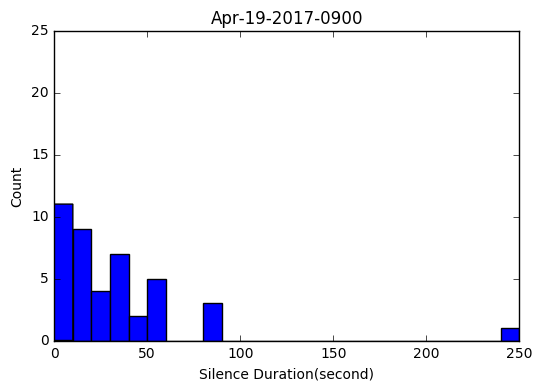

In [22]:
plt.hist(si_duration_agg,bins = range(0,int(np.max(si_duration)+20),10))
plt.title(start_str[9:])
plt.xlabel('Silence Duration(second)')
plt.ylabel('Count')
plt.ylim(0,25)
plt.show()